In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from game import *

In [5]:
# for reproducibility
my_seed = 2786
np.random.seed(my_seed)
torch.manual_seed(my_seed)

# Creating The Q-Table
action_space_size = 4  # Up-left-down-right
state_space_size = 2**12 # All possible permutations of bitstring og length 12
print("action_space_size: ", action_space_size)
print("state_space_size: ", state_space_size)
q_table = np.zeros((state_space_size, action_space_size))
print("Q table size: ", q_table.shape)

# View good score games while training ?
view_games = True

# Stats for plotting
loss_means = []
highest_scores = []
best_play_models = []

# Initializing Q-Learning Parameters
num_episodes = 75000
max_steps_per_episode = 1000000

learning_rate = 0.0005
discount_rate = 0.95

exploration_rate = 1  # Initially exploring (all q-table vals = 0 at beginning)
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.0001

# The Q-Learning Algorithm Training Loop
rewards_all_episodes = []
action_map = {"up": 0, "down": 1, "left": 2, "right": 3}

high_score = 0
high_score_seed = 0
for episode in tqdm(range(num_episodes)):
    agent = SimpleSnakeApp(seed=my_seed+episode,
                           Q_table=q_table,
                           display_gameplay=False)

    done = False
    rewards_current_episode = 0
    my_random_flag = False

    for step in range(max_steps_per_episode):

        # Exploration-exploitation trade-off
        exploration_rate_threshold = np.random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            # Use Q table
            my_random_flag = False
        else:
            # Random action
            my_random_flag = True

        # Take new action
        reward, running, action, _state, new_state = agent.step(my_random_flag)
        _state = int(tensor_2_string(_state), 2)
        new_state = int(tensor_2_string(new_state), 2)
        action = action_map[action]
        done = not running

        # Update Q-table (using Bellman equation for Optimal Q-value function)
        q_table[_state, action] = q_table[_state, action] * (1 - learning_rate) + learning_rate * (
                    reward + discount_rate * np.max(q_table[new_state, :]))

        # Add new reward
        rewards_current_episode += reward

        if done:
            break
        if step == max_steps_per_episode - 1:
            print("Ej caramba")

    # Exploration rate decay
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(
        -exploration_decay_rate * episode)

    # Add current episode reward to total rewards list
    rewards_all_episodes.append(rewards_current_episode)

    if rewards_current_episode > high_score:
        high_score = rewards_current_episode
        high_score_seed = my_seed+episode
        saveQtable(filename="bestqtable.txt",qtable=q_table)

action_space_size:  4
state_space_size:  4096
Q table size:  (4096, 4)


100%|██████████| 75000/75000 [07:26<00:00, 167.85it/s]


In [6]:
print("High score:", high_score)

High score: 76


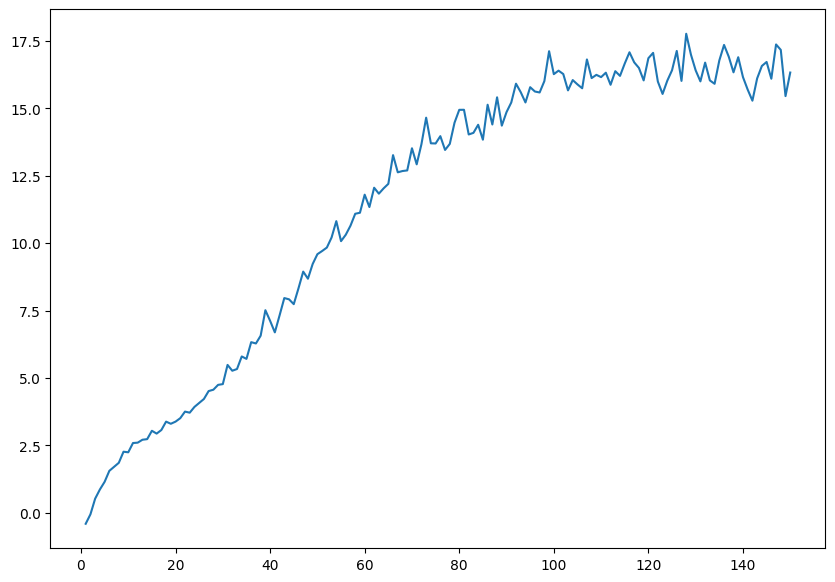

In [7]:
# Calculating average over 100's of episodes
batch_size = 500
avg_rewards = []
for batch in range(int(num_episodes/batch_size)):
    avg_rewards.append(np.mean(rewards_all_episodes[batch_size * batch : batch_size * (batch + 1)]))

# Plot reward of each 'episode'
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(list(range(1, len(avg_rewards)+1)), avg_rewards)
plt.show()

In [12]:
best_q_table = np.loadtxt(fname="Qtables/bestqtable.txt")
Game = SimpleSnakeApp(seed=high_score_seed-2,
                      Q_table=best_q_table,
                      display_gameplay=True)
Game.on_execute()
pygame.display.quit()
pygame.quit()


NÅR SLANGEN RAMMER SLANGEN HEHE
